In [1]:
import sys; sys.path.append('../')
import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE

from src.data_loader import load_data

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

In [2]:
plt.rcParams["figure.figsize"] = (20,10)
plt.style.use('seaborn-whitegrid')

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier, RandomForestClassifier, VotingClassifier)
from sklearn.svm import SVC
models = [
    LinearDiscriminantAnalysis, KNeighborsClassifier, GaussianNB,
    DecisionTreeClassifier, ExtraTreeClassifier, AdaBoostClassifier, BaggingClassifier,
    ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, SVC
]

## Cluster Oversampling using SMOTE

In [4]:
clusters, _ = load_data('../data/all_clusters.txt')
clusters = clusters.drop(['file_origin', 'file_destination'], axis=1).reset_index()

In [5]:
#Delete columns with one value
for col in clusters.columns:
    if len(clusters[col].unique()) == 1:
        clusters.drop(col,inplace=True,axis=1)

        #Delete columns with one value
for col in clusters.columns:
    if len(clusters[col].unique()) == 1:
        clusters.drop(col,inplace=True,axis=1)

clusters['classification'] = (
    ((clusters['classification'] != 'Vegetation') & (clusters['classification'] != 'Limit_effect'))
)

In [6]:
data = clusters.replace('None', np.nan).dropna(axis=0)

X = data.drop('classification', axis=1)
X = (X - X.mean()) / X.std()
y = data['classification']

In [7]:
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=40)

bar_plot = []
for train_index, test_index in splitter.split(X, y):
    X_train, y_train = SMOTE(n_jobs=-1).fit_resample(X.iloc[train_index], y.iloc[train_index])
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    
    performances = []
    for Model in models:
        try:
            model = Model()
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            performances.append([
                Model.__name__, len(y_pred),
                sum(y_pred), sum(y_test),
                sum(y_test & y_pred)
            ])
        except Exception as e:
            pass
    bar_plot.append(performances)

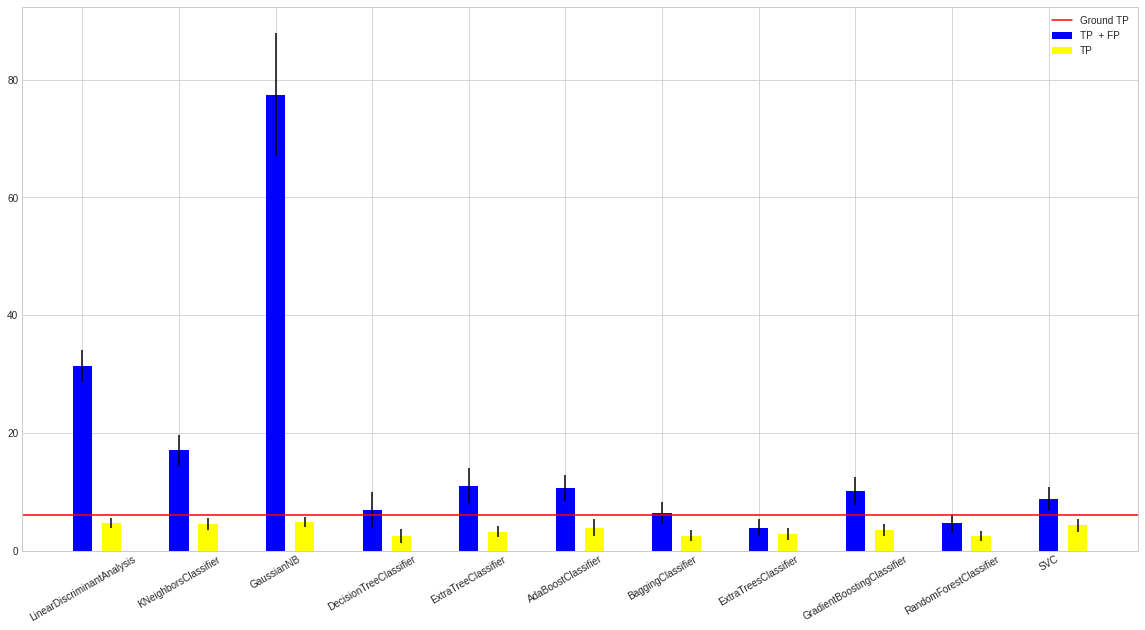

In [8]:
tp_tfs = []
tp_tfs_err = []
tps = []
tps_err = []
for model_index, model in enumerate([e[0] for e in bar_plot[0]]):
    tp_fp, tp = [], []
    for split in bar_plot:
        tp_fp.append(split[model_index][2])
        tp.append(split[model_index][4])

    tp_tfs.append(np.array(tp_fp).mean())
    tp_tfs_err.append(np.array(tp_fp).std())
    tps.append(np.array(tp).mean())
    tps_err.append(np.array(tp).std())

x = np.arange(len(tp_tfs))
plt.bar(x, tp_tfs, yerr=tp_tfs_err, width=0.2, label='TP  + FP', color='blue')
plt.bar(x + 0.3, tps, yerr=tps_err, width=0.2, label='TP', color='yellow')

plt.axhline(bar_plot[0][0][3], color='red', label='Ground TP')
plt.xticks(x, [e[0] for e in bar_plot[0]], rotation=30)
plt.legend()